In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,sklearn,pandas
%watermark -v -p cv2,PIL,matplotlib
%watermark -v -p torch,torchvision,torchaudio,pytorch_lightning
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

from IPython.display import display, HTML, Javascript
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

def _IMPORT_(x):
    try:
        exec(x, globals())
    except:
        pass


CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
sklearn 0.24.0
pandas 1.1.5
CPython 3.6.9
IPython 7.16.1

cv2 4.5.1
PIL 6.2.2
matplotlib 3.3.3
CPython 3.6.9
IPython 7.16.1

torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101
torchaudio not installed
pytorch_lightning 1.2.0


In [2]:
###
### Common ###
###

import sys, os, io, time, random, math
import json, base64, requests

import os.path as osp

_IMPORT_('import numpy as np')
_IMPORT_('import pandas as pd')
_IMPORT_('from tqdm.notebook import tqdm')

def print_progress_bar(x):
    print('\r', end='')
    print('Progress: {}%:'.format(x), '%s%s' % ('▋'*(x//2), '.'*((100-x)//2)), end='')
    sys.stdout.flush()

###
### Torch ###
###

_IMPORT_('import torch')
_IMPORT_('import torch.nn as nn')
_IMPORT_('import torch.nn.functional as F')
_IMPORT_('import torch.optim as O')
_IMPORT_('from torchvision import models as M')
_IMPORT_('from torchvision import transforms as T')
_IMPORT_('from torch.utils.data import Dataset, DataLoader')

###
### Display ###
###

_IMPORT_('import cv2')
_IMPORT_('from PIL import Image')
_IMPORT_('from torchvision.utils import make_grid')
_IMPORT_('import matplotlib.pyplot as plt')
_IMPORT_('import plotly')
_IMPORT_('import plotly.graph_objects as go')

# plotly.offline.init_notebook_mode(connected=False)

def show_video(video_path, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if video_path.startswith('http'):
        data_url = video_path
    else:
        mp4 = open(video_path, 'rb').read()
        data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
    return HTML('<video %s %s controls src="%s" type="video/mp4"/>' % (W, H, data_url))

def show_image(image_path, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if image_path.startswith('http'):
        data_url = image_path
    else:
        img = open(image_path, 'rb').read()
        data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))

In [3]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from random import randrange, randint
import matplotlib.animation as animation
import glob

In [4]:
DATASET_ROOT = '/data/datasets/cv/repnet_datasets'

## Countix Dataset

In [139]:
class CountixSynthDataset(Dataset):
    def __init__(self, data_root, phase, frame_size=112, num_frames=64):
        self.data_root = data_root
        self.num_frames = num_frames
        self.frame_size = (frame_size, frame_size) if isinstance(frame_size, int) else frame_size
        self.data = self._make_valid_data(data_root, phase)
        
    def _make_valid_data(self, data_root, phase):
        synthvids_paths = glob.glob(f'{data_root}/synthvids/*.mp4')
        data = []
        df_all = pd.read_csv(f'{data_root}/countix/countix_{phase}.csv')
        valid_index = []
        valid_paths = []
        for i in range(len(df_all)):
            vpath = f'{data_root}/{phase}vids/{phase}{i}.mp4'
            if osp.exists(vpath):
                valid_index.append(i)
                valid_paths.append(vpath)
        df_valid = df_all.iloc[valid_index]
        valid_counts = df_valid['count']
        valid_video_id = df_valid['video_id']
        random_synth = random.choices(synthvids_paths, k=len(valid_paths))
        return list(zip(valid_paths, valid_counts, random_synth, valid_video_id))
    
    def _get_frames(self, path):
        frames = []
        if path is None:
            path = self.path
        
        cap = cv2.VideoCapture(path)
        while cap.isOpened():
            ret, frame = cap.read()
            if ret is False:
                break
            img = Image.fromarray(frame)
            frames.append(img)
        
        cap.release()
        assert len(frames) > 0, path
        return frames
    
    def _skip_frames(self, frames, count):
        new_frames = []
        l = len(frames)
        for i in range(1, count + 1):
            new_frames.append(frames[i * l // count - 1])
        return new_frames

    def __getitem__(self, index):
        cvid_path, cvid_count, svid_path, _ = self.data[index]
        cframes = self._get_frames(cvid_path)
        sframes = self._get_frames(svid_path)
        
        cvid_len = min(len(cframes), randint(int(0.7 * self.num_frames), self.num_frames))
        head_len = randint(0, self.num_frames - cvid_len)
        tail_len = self.num_frames - cvid_len - head_len
        
        cframes = self._skip_frames(cframes, cvid_len)
        sframes = self._skip_frames(sframes, head_len + tail_len)

        same = np.random.choice([0, 1], p = [0.5, 0.5])
        if same:
            final_frames = [cframes[0] for i in range(head_len)]
            final_frames.extend(cframes)        
            final_frames.extend([cframes[-1] for i in range(tail_len)] )
        else:
            final_frames = sframes[:head_len]
            final_frames.extend(cframes)
            final_frames.extend(sframes[head_len:])      
            
        # TODO DEBUG
        if index == 0:
            self.final_frames = final_frames
        
        Xlist = []
        for img in final_frames:
            preprocess = T.Compose([
                T.Resize(self.frame_size),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
            Xlist.append(preprocess(img).unsqueeze(0))
        
        p_len = cvid_len / cvid_count
        p_len = p_len if 1 < p_len < int(self.num_frames / 2) else 0
        
        y1 = np.full((self.num_frames, 1), fill_value=p_len)
        y2 = np.ones((self.num_frames, 1)) 
        
        for i in range(self.num_frames):
            if i < head_len or i > (self.num_frames - tail_len):
                y1[i] = 0
                y2[i] = 0
                Xlist[i] = F.dropout(Xlist[i], 0.2)
                
        X = torch.cat(Xlist)
        y1 = torch.FloatTensor(y1)
        y2 = torch.FloatTensor(y2)
        y3 = torch.FloatTensor([cvid_count])
        
        return X, y1, y2, y3

    def __len__(self):
        return len(self.data)

In [143]:
test_dataset = CountixSynthDataset(DATASET_ROOT, 'train')
X, y1, y2, y3 = next(iter(test_dataset))

In [146]:
test_dataset.data[3900:3930]

[('/data/datasets/cv/repnet_datasets/trainvids/train4059.mp4',
  4,
  '/data/datasets/cv/repnet_datasets/synthvids/train379.mp4',
  '7j13Tljq-kA'),
 ('/data/datasets/cv/repnet_datasets/trainvids/train4060.mp4',
  4,
  '/data/datasets/cv/repnet_datasets/synthvids/train1489.mp4',
  '7qlOB8izWVg'),
 ('/data/datasets/cv/repnet_datasets/trainvids/train4061.mp4',
  6,
  '/data/datasets/cv/repnet_datasets/synthvids/train1597.mp4',
  '8zGgtYxbeDE'),
 ('/data/datasets/cv/repnet_datasets/trainvids/train4062.mp4',
  4,
  '/data/datasets/cv/repnet_datasets/synthvids/train1302.mp4',
  '9aCHFjdMLdY'),
 ('/data/datasets/cv/repnet_datasets/trainvids/train4063.mp4',
  3,
  '/data/datasets/cv/repnet_datasets/synthvids/train1375.mp4',
  '-h-caDqncrY'),
 ('/data/datasets/cv/repnet_datasets/trainvids/train4064.mp4',
  6,
  '/data/datasets/cv/repnet_datasets/synthvids/train1170.mp4',
  '-4E8BFFUJ4Q'),
 ('/data/datasets/cv/repnet_datasets/trainvids/train4065.mp4',
  8,
  '/data/datasets/cv/repnet_datasets/sy

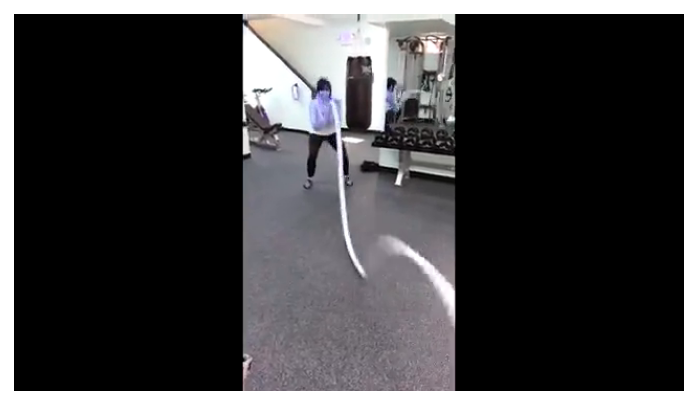

In [113]:
fig = plt.figure()
plt.axis('off')
frames = []
for img in test_dataset.final_frames:
    frames.append([plt.imshow(img)])
anim = animation.ArtistAnimation(
    fig, frames, interval=50, blit=True,
    repeat_delay=1000)
HTML(anim.to_html5_video())

## SyntheticDataset

```
     -----------|------------|------------|----------
                  midpos          highpos
```

In [27]:
def getRandomTransformParameter(high, mid, low, length=64):
    retarr = []
    midpos = randint(length//4, length//2)
    highpos = randint(length//2, 3*length//4)
    
    retarr = list(np.linspace(start=low, stop=mid, num=midpos))
    retarr.extend(list(np.linspace(start=mid, stop=high, num=highpos-midpos)))
    retarr.extend(list(np.linspace(start=high, stop=mid, num=length - highpos)))
    
    retarr = np.array(retarr)
    retarr = retarr[::random.choice([-1, 1])]
    return retarr

In [47]:
getRandomTransformParameter(0.9, 0.75, 0.5)

array([0.5       , 0.50806452, 0.51612903, 0.52419355, 0.53225806,
       0.54032258, 0.5483871 , 0.55645161, 0.56451613, 0.57258065,
       0.58064516, 0.58870968, 0.59677419, 0.60483871, 0.61290323,
       0.62096774, 0.62903226, 0.63709677, 0.64516129, 0.65322581,
       0.66129032, 0.66935484, 0.67741935, 0.68548387, 0.69354839,
       0.7016129 , 0.70967742, 0.71774194, 0.72580645, 0.73387097,
       0.74193548, 0.75      , 0.75      , 0.76071429, 0.77142857,
       0.78214286, 0.79285714, 0.80357143, 0.81428571, 0.825     ,
       0.83571429, 0.84642857, 0.85714286, 0.86785714, 0.87857143,
       0.88928571, 0.9       , 0.9       , 0.890625  , 0.88125   ,
       0.871875  , 0.8625    , 0.853125  , 0.84375   , 0.834375  ,
       0.825     , 0.815625  , 0.80625   , 0.796875  , 0.7875    ,
       0.778125  , 0.76875   , 0.759375  , 0.75      ])

In [ ]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms

import cv2
import glob
import random
from tqdm import tqdm
from random import randrange, randint
import math, base64, io, os, time
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn.functional as F

#returns a 64 length array that goes low->mid->high->mid

def getRandomTransformParameter(high, mid, low, length=64):
    retarr = []
    midpos = randint(length//4, length//2)
    highpos = randint(length//2, 3*length//4)
    
    retarr = list(np.linspace(start=low, stop=mid, num=midpos))
    retarr.extend(list(np.linspace(start=mid, stop=high, num=highpos-midpos)))
    retarr.extend(list(np.linspace(start=high, stop=mid, num=length - highpos)))
    
    retarr = np.array(retarr)
    retarr = retarr[::random.choice([-1, 1])]
    return retarr

def randomTransform(frames):
    scaleParams = getRandomTransformParameter(0.9, 0.75, 0.5)
    zRotateParams = getRandomTransformParameter(45, 0, -45)
    xRotateParams = getRandomTransformParameter(0.2, 0.0, -0.2, 32)
    yRotateParams = getRandomTransformParameter(0.2, 0.0, -0.2, 32)
    
    h, w, c = frames[0].shape
    erParams = [randint(0,h-h/2), randint(0,w-w/2), h//2, w//2]
    erVal = getRandomTransformParameter(1.0, 0.5, 0.0)
    horizTransParam = (h/4)*getRandomTransformParameter(0.4, 0.0, -0.4)
    verticalTransParam = (w/4)*getRandomTransformParameter(0.4, 0.0, -0.4)
    
    newFrames = []

    for i, frame in enumerate(frames):
        img = Image.fromarray(frame)
        preprocess = transforms.Compose([
            transforms.Resize((112, 112), 2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        frame = preprocess(img).unsqueeze(0)
        #frame = transforms.functional.erase(frame, erParams[0] , erParams[1], erParams[2], erParams[3], erVal[i])

        frame = transforms.functional.affine(frame,
                                             zRotateParams[i],
                                             [horizTransParam[i], verticalTransParam[i]],
                                             scaleParams[i],
                                             [0.0, 0.0],
                                             0)
        newFrames.append(frame)
    
    frames = torch.cat(newFrames)
        
    return frames

In [114]:
class SyntheticDataset(Dataset):
    
    def __init__(self, videoPath, filename, extension, length):
        
        self.sourcePath = videoPath + '/' + filename + '.' + extension
        self.length = length

    def __getitem__(self, index):

        X, periodLength, period, f = self.generateRepVid()
        
        return X, periodLength, index, period, f
    
    def getPeriodDist(self, samples):
        arr = np.zeros(32,)
        
        for i in tqdm(range(samples)):
            _, _, p = self.generateRepVid()
            arr[p] += 1
        return arr
    
    def getNFrames(self, frames, n):
        
        newFrames = []
        for i in range(1, n + 1):
            newFrames.append(frames[i * len(frames)//n  - 1])
            
        assert(len(newFrames) == n)
        return newFrames
            
        
    def generateRepVid(self):
        
        while True:
            path = random.choice(glob.glob(self.sourcePath))
            assert os.path.exists(path), "No file with this pattern exist" + self.sourcePath

            cap = cv2.VideoCapture(path)
            total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if total > 64:
                break
            else:
                os.remove(path)
        
        mirror = np.random.choice([0, 1], p = [0.8, 0.2])
        halfperiod = randint(2 , 31) // (mirror + 1)
        period = (mirror + 1) * halfperiod
        count = randint(max(2, 16//period), 64//(period))
        
        clipDur = randint(min(total//(64/period - count + 1), max(period, 30)), 
                          min(total//(64/period - count + 1), 60))
        
        print(period, count, clipDur, total, total//(64/period - count + 1))

        repDur = count * clipDur
        noRepDur =  int((64 / (period*count) - 1) * repDur)
        assert(noRepDur >= 0)
        begNoRepDur = randint(0,  noRepDur)
        endNoRepDur = noRepDur - begNoRepDur
        totalDur = noRepDur + repDur
            
        startFrame = randint(0, total - (clipDur + noRepDur))
        cap.set(cv2.CAP_PROP_POS_FRAMES, startFrame)
        
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if ret is False or len(frames) == clipDur + noRepDur:
                break
            frame = cv2.resize(frame , (112, 112), interpolation = cv2.INTER_AREA)
            frames.append(frame)
        
        cap.release()
        
        numBegNoRepFrames = begNoRepDur*64//totalDur
        periodLength = np.zeros((64, 1))
        begNoRepFrames = self.getNFrames(frames[:begNoRepDur], numBegNoRepFrames)
        finalFrames = begNoRepFrames
        print(len(finalFrames ))
        
        
        repFrames = frames[begNoRepDur : -endNoRepDur]
        repFrames.extend(repFrames[::-1])
        
        if len(repFrames) >= period:
            curf = numBegNoRepFrames
            for i in range(count):
                if period > 18:
                    noisyPeriod = np.random.choice([max(period-1, 2), period, min(31, period + 1)])
                    noisyPeriod = min(noisyPeriod, 64 - curf)
                else:
                    noisyPeriod = period
                noisyFrames = self.getNFrames(repFrames, noisyPeriod)
                finalFrames.extend(noisyFrames)

                for p in range(noisyPeriod):
                    
                    try:
                        periodLength[curf] = noisyPeriod
                    except: 
                        print(curf, numBegNoRepFrames, totalDur, begNoRepDur)
                    assert(noisyPeriod < 32)
                    curf+=1
                                                
        else:
            period = 0
            
        numEndNoRepFrames = 64 - len(finalFrames) 
        endNoRepFrames = self.getNFrames(frames[-endNoRepDur:], numEndNoRepFrames)
        finalFrames.extend(endNoRepFrames)
        
        print(len(finalFrames))
        frames = randomTransform(finalFrames)
        
        numBegNoRepFrames = begNoRepDur*64//totalDur
        if count == 1:
            numEndNoRepFrames = 64 - numBegNoRepFrames
            period = 0
            
        #assert(len(frames) == 64)
        
        #frames = F.dropout(frames, p = 0.1)
        periodLength = torch.LongTensor(periodLength)
        return frames, periodLength, period, finalFrames

    def __len__(self):
        return self.length

        
testDatasetS = SyntheticDataset(
    f'{DATASET_ROOT}/synthvids', 'train*', 'mp4', 2000)

it = iter(testDatasetS)
x, y1, y2, period, final_frames= next(it);

12 3 32 250 75.0
21
64


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:258: UserWarning:

Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:990: UserWarning:

Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.



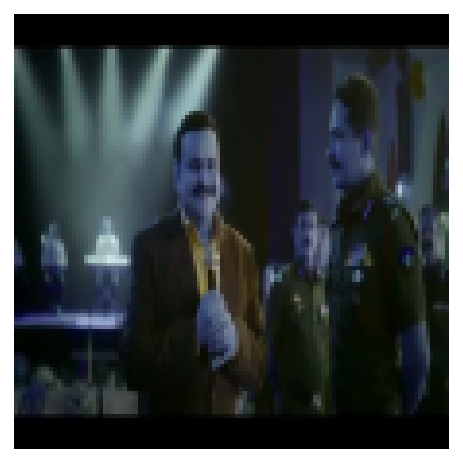

In [115]:
fig = plt.figure()
plt.axis('off')
frames = []
for img in final_frames:
    frames.append([plt.imshow(img)])
anim = animation.ArtistAnimation(
    fig, frames, interval=50, blit=True,
    repeat_delay=3000)
HTML(anim.to_html5_video())

In [116]:
DATA_PATH = '/raceai/data/media/videos/repnet_mix_test.mp4'
cap = cv2.VideoCapture(DATA_PATH)
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if ret is False:
        break
    frames.append(frame)
cap.release()

In [117]:
len(frames)

634

In [119]:
a = [1,2,3]
b = [3,4,5]

c = [a, b]
c



[[1, 2, 3], [3, 4, 5]]

In [120]:
random.shuffle(c)

In [126]:
torch.nn.functional.threshold(torch.IntTensor([1,2,3,4,5]), 1, 0, )


tensor([0, 2, 3, 4, 5], dtype=torch.int32)